<a href="https://colab.research.google.com/github/fguiso/meta-learners/blob/main/real_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [170]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

np.random.seed(2079)

In [133]:
# Change this based on who is running the code
path = '/content/drive/MyDrive/ML Tools Project Data/'
# path = '/content/drive/MyDrive/NYU Year 2 S2/ML/meta-learners/'

In [134]:
gotv = pd.read_csv(path+'gotv.csv')

In [135]:
gotv #.head()

,sex,g2000,g2002,p2000,p2002,p2004,age,treatment,voted
0,1,1,1,0,1,0,65,1,0
1,0,1,1,0,1,0,59,1,0
2,1,0,0,0,0,0,25,0,0
3,0,1,1,0,1,0,47,0,1
4,1,1,1,0,1,0,50,0,1
...,...,...,...,...,...,...,...,...,...
229456,1,1,1,0,1,1,63,0,1
229457,1,1,1,1,0,1,51,0,0
229458,0,1,0,0,0,0,48,0,0
229459,1,1,1,1,1,1,69,0,1


In [136]:
gotv.columns

Index(['sex', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'age', 'treatment',
       'voted'],
      dtype='object')

# Define base learner

In [203]:
# XGBoost

# Base learner
base_learner = GradientBoostingClassifier()

# Base learner of the second stage
base_learner_2 = GradientBoostingRegressor()

# Classifier to get propensity scores
prop_classifier = GradientBoostingClassifier()

# # Random Forest

# # Base learner
# base_learner = RandomForestClassifier(n_estimators=1_000,random_state=50)

# # Base learner of the second stage
# base_learner_2 = RandomForestRegressor()

# # Classifier to get propensity scores
# prop_classifier = RandomForestClassifier()


# T-learner on voter turnout experiment

Estimate control response function $\mu_0(x) = E[Y (0) | X = x]$ using observations in the
control group

Estimate treatment response function $\mu_1(x) = E[Y (1) | X = x]$ using observations in the treatment group

CATE estimator is given by $\hat{\tau}^T(x) = \hat{\mu_1}(x)−\hat{\mu_0}(x)$



In [204]:
x_vars = ['sex', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'age']
def data_prep(dataset, x_vars = ['sex', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'age']):
    # Create dataset for voter turnout experiment
    # Y: outcome (here, whether individual i voted or not)
    # W: treatment
    # X: covariates (here, whether individual i voted or not)

    data = pd.DataFrame()
    data['Y'] = dataset['voted'].copy()
    data['W'] = dataset['treatment'].copy()
    data[x_vars] = dataset[x_vars].copy()
    return data

In [205]:
data = data_prep(gotv)
data

,Y,W,sex,g2000,g2002,p2000,p2002,p2004,age
0,0,1,1,1,1,0,1,0,65
1,0,1,0,1,1,0,1,0,59
2,0,0,1,0,0,0,0,0,25
3,1,0,0,1,1,0,1,0,47
4,1,0,1,1,1,0,1,0,50
...,...,...,...,...,...,...,...,...,...
229456,1,0,1,1,1,0,1,1,63
229457,0,0,1,1,1,1,0,1,51
229458,0,0,0,1,0,0,0,0,48
229459,1,0,1,1,1,1,1,1,69


# Define T-, S-, and X-learners

In [206]:
def t_learner(data, x_vars, base_learner):
    # separate outcomes for treated and untreated individuals
    data['Y_0'] = data[data['W']==0]['Y']
    data['Y_1'] = data[data['W']==1]['Y']

    # create separate dataframes for treated and untreated so we can fit base_learner
    treatment_group = data[x_vars+['Y_1']].dropna()
    control_group = data[x_vars+['Y_0']].dropna()

    # Estimate control group response function
    model_0 = base_learner
    # This is fit on the control group
    model_0.fit(control_group[x_vars],control_group['Y_0'])
    mu_0 = model_0.predict_proba(data[x_vars])[:,1]

    # Estimate treatment group response function
    model_1 = base_learner
    # This is fit on the treatment group
    model_1.fit(treatment_group[x_vars],treatment_group['Y_1'])
    mu_1 = model_1.predict_proba(data[x_vars])[:,1]

    cate_t = mu_1 - mu_0

    return cate_t

In [207]:
cate_t = t_learner(data, x_vars, base_learner)
cate_t.shape

(229461,)

# S-learner on voter turnout experiment

Estimate the combined response function $\mu(x,w) := E[Y | X = x,W = w]$
* where $Y =Y(w)$
* Let $\hat{\mu}(x,w)$ be our estimate for $\mu(x,w)$

CATE estimator is given by $\hat{\tau}^S(x) = \hat{\mu}(x,1)−\hat{\mu}(x,0)$


In [208]:
def s_learner(data, x_vars, base_learner):
    # Estimate combined response function (here, we include W as an input)
    model_combined = base_learner
    model_combined.fit(data[x_vars+['W']],data['Y'])

    # Create dataframe for predictions
    data_w = data[x_vars].copy()

    # Pretend everyone is treated
    # Estimated response when W = 1
    data_w['W=1'] = 1

    # Pretend everyone is control
    # Estimated response when W = 0
    data_w['W=0'] = 0

    # Estimate individual response under assumption that everyone is treated (i.e. W=1)
    mu_1_s = model_combined.predict_proba(data_w[x_vars+['W=1']])[:,1]

    # Estimate individual response under assumption that everyone is in control group (i.e. W=0)
    mu_0_s = model_combined.predict_proba(data_w[x_vars+['W=0']])[:,1]

    cate_s = mu_1_s - mu_0_s

    return cate_s


In [209]:
cate_s = s_learner(data, x_vars, base_learner)
cate_s.shape

(229461,)

# X-learner on voter turnout experiment

Fit treatment and control response estimators $\hat{\mu}_1$ and $\hat{\mu}_0$ (T-learner).

* Use $\hat{\mu}_1$ to get imputed treatment effect for the control group.

* Use $\hat{\mu}_0$ to get imputed treatment effect for the treatment group.

"Base learners of the second stage" (note: results seem to be **very** sensitive to the choice of model for this)

* Let $\hat{\tau}_0(x)$ be a CATE estimate fit to control group

* Let $\hat{\tau}_1(x)$ be a CATE estimate fit to treatment group

Final estimator is a weighted average of the two estimates:

$\hat{\tau}(x) = g(x)\hat{\tau}_0(x)+(1−g(x))\hat{\tau}_1(x)$ where $g\in[0,1]$ is a weight function

Authors recommend taking $g(x) = \pi(x)$ or $g(x) = \hat{\pi}(x)$ if $\pi$ is not known

#### Base learners of the second stage:
Use any supervised learning or regression method(s) to estimate $\hat{\tau}_0(x)$ in two ways: using the imputed treatment effects as the response variable in the treatment group to obtain $\hat{\tau}_1(x)$ and similarly in the control group to obtain $\hat{\tau}_0(x)$. Call the supervised learning or regression algorithms base learners of the second stage.

In [210]:
def x_learner(data, x_vars, base_learner, base_learner_2, prop_classifier):
    """
    Input:
    data: pd.Dataframe
    base_learner: base learner used to get mu_0, mu_1
    base_learner_2: base learner of the second stage (used to get tau_0, tau_1)
    prop_classifier: classifier to estimate propensity score
    Output:
    CATE estimate
    """
    # separate outcomes for treated and untreated individuals
    data['Y_0'] = data[data['W']==0]['Y']
    data['Y_1'] = data[data['W']==1]['Y']

    # create separate dataframes for treated and untreated so we can fit base_learner
    treatment_group = data[x_vars+['Y_1']].dropna()
    control_group = data[x_vars+['Y_0']].dropna()

    # Estimate control response function
    # Same as T-learner
    model_0 = base_learner 
    model_0.fit(control_group[x_vars],control_group['Y_0'])

    # Use mu_0 to impute potential outcome Y(0) for TREATMENT group
    treatment_group['y_hat_0'] = model_0.predict_proba(treatment_group[x_vars])[:,1]

    # Estimate treatment response function
    # Same as T-learner
    model_1 = base_learner
    model_1.fit(treatment_group[x_vars],treatment_group['Y_1'])

    # Use mu_1 to impute  potential outcome Y(1) for CONTROL group
    control_group['y_hat_1'] = model_1.predict_proba(control_group[x_vars])[:,1]

    # Add treatment flag
    treatment_group['W'] = 1
    control_group['W'] = 0

    imputed_data = pd.concat((treatment_group,control_group))

    # Use imputed potential outcomes to imputed treatment effects 
    imputed_data['diff_w=0'] = imputed_data['y_hat_1'] - imputed_data['Y_0'] # y_hat_1 is NaN for W=1
    imputed_data['diff_w=1'] = imputed_data['Y_1'] - imputed_data['y_hat_0'] # y_hat_0 is NaN for W=0

    # We have imputed "full" data
    control_imp = imputed_data[imputed_data['W']==0][x_vars+['diff_w=0']]
    treatment_imp = imputed_data[imputed_data['W']==1][x_vars+['diff_w=1']]

    # Estimate tau_0, tau_1 using "base learners of the second stage"

    # Fit on imputed data (treatment group)
    control_model = base_learner_2
    control_model.fit(control_imp[x_vars],control_imp['diff_w=0'])
    # tau_0 is a CATE estimate fit to the control group
    tau_0 = control_model.predict(data[x_vars])

    # Fit on imputed data (control group)
    treatment_model = base_learner_2
    treatment_model.fit(treatment_imp[x_vars],treatment_imp['diff_w=1'])
    # tau_1 is a CATE estimate fit to the treatment group
    tau_1 = control_model.predict(data[x_vars])

    # Estimate propensity score
    m_prop = prop_classifier
    m_prop.fit(imputed_data[x_vars],imputed_data['W'])
    g = m_prop.predict_proba(data[x_vars])[:,1]
    
    cate_x = g*tau_1 + (1-g)*tau_0

    return cate_x

In [211]:
cate_x = x_learner(data=data,x_vars=x_vars,base_learner=base_learner,base_learner_2=base_learner_2, prop_classifier=prop_classifier)
cate_x.shape

(229461,)

In [212]:
# Create dataframe with T-, S-, and X-learner CATE
df = data.copy()
df['cate_t'] = cate_t
df['cate_s'] = cate_s
df['cate_x'] = cate_x

In [213]:
(df['cate_t']>0).sum(), (df['cate_t']<0).sum()

(197336, 32125)

In [214]:
(df['cate_s']>0).sum(), (df['cate_s']<0).sum()

(222718, 6743)

In [215]:
(df['cate_x']>0).sum(), (df['cate_x']<0).sum()

(212393, 17068)

# Figure 2 

In [216]:
def make_fig2(data,cate):
    """
    data: dataset with Y, W, and covariates
    cate: str() either 'x','t',or 's'
    """
    # Create subgroups: count past election participation (ranges from 0 to 5)  
    df['vote_history'] = data['g2000']+data['g2002']+data['p2000']+data['p2002']+data['p2004']
    
    # indicators for individuals for which CATE is negative (positive)
    df[f"cate_{cate}<0"] = 1*(df[f"cate_{cate}"]<0)
    df[f"cate_{cate}>0"] = 1*(df[f"cate_{cate}"]>0)

    # Proportion of voters for which CATE is positive
    df.groupby(by='vote_history',axis=0).mean()[[f"cate_{cate}>0",f"cate_{cate}<0",f"cate_{cate}"]]
    
    proportions = df.groupby(by='vote_history',axis=0).agg({f"cate_{cate}>0": ['sum'], 'Y':  ['count']})
 
    # Creating dataset
    est = f"cate_{cate}"

    data_0 = df[df['vote_history'] == 0][est]*100
    data_1 = df[df['vote_history'] == 1][est]*100
    data_2 = df[df['vote_history'] == 2][est]*100
    data_3 = df[df['vote_history'] == 3][est]*100
    data_4 = df[df['vote_history'] == 4][est]*100
    data_5 = df[df['vote_history'] == 5][est]*100
    
    # Each box is based on data for a specific subgroup
    plot_data = [data_0, data_1, data_2, data_3, data_4, data_5]

    # Width is proportional to the size of the group
    subgroup_counts = df.groupby('vote_history').agg({f"cate_{cate}":'count'}).values.flatten()
    width_data = [x/len(df) for x in subgroup_counts]

    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_axes([0, 0, 1, 1])

    # Format y axis as percentage
    fmt = '%.0f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    # Labels
    plt.xlabel('Cumulative Voting History')
    plt.ylabel('CATE')
    plt.title(f"{str.upper(cate)}-learner: Figure 2 (Lower) using {str(base_learner)[:str(base_learner).find('(')]} as base learner")

    plt.grid()
    bp = ax.boxplot(plot_data, widths=width_data,positions=[0,1,2,3,4,5],showfliers=False)
    plt.savefig(path+str(cate)+'fig2_lower_BL='+str(base_learner)[:str(base_learner).find('(')])
    plt.show()
    plt.close()
    
    return df 


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


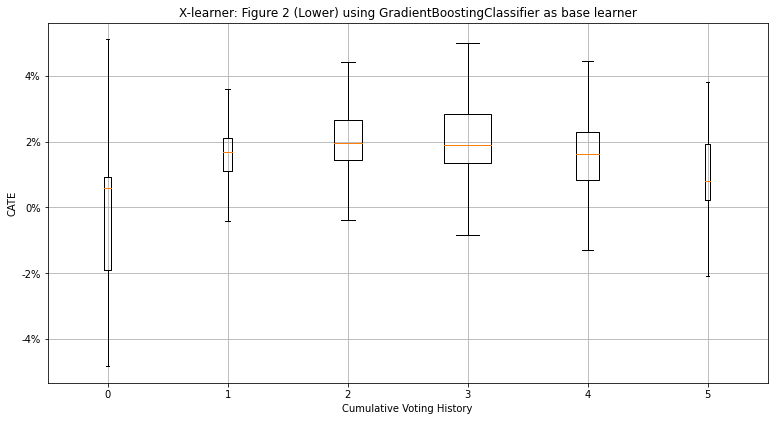

In [217]:
df_cate_x = make_fig2(data=df,cate='x')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


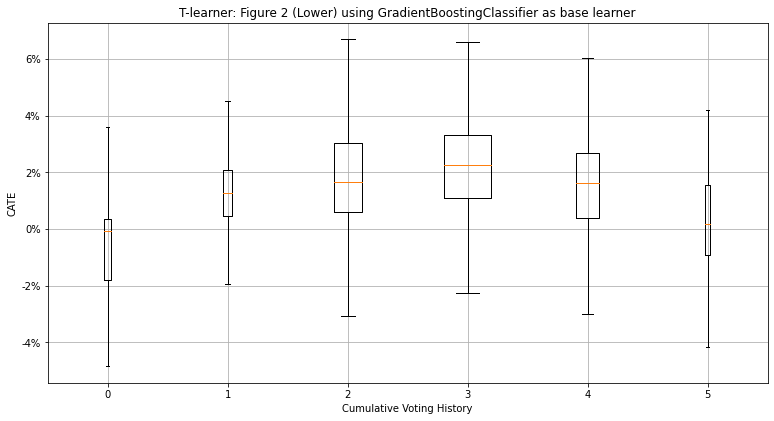

In [218]:
df_cate_t = make_fig2(data=df,cate='t')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


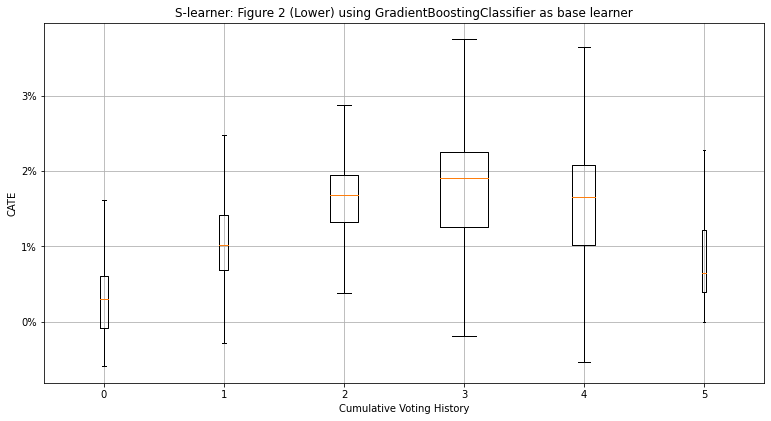

In [219]:
df_cate_s = make_fig2(data=df,cate='s')

In [220]:
def make_fig3(data,cate):
    """
    data: dataset with Y, W, and covariates
    cate: str() either 'x','t',or 's'
    """
    print(cate+'-learner')
    # Create subgroups: count past election participation (ranges from 0 to 5)  
    df['vote_history'] = data['g2000']+data['g2002']+data['p2000']+data['p2002']+data['p2004']
    
    # indicators for individuals for which CATE is negative (positive)
    df[f"cate_{cate}<0"] = 1*(df[f"cate_{cate}"]<0)
    df[f"cate_{cate}>0"] = 1*(df[f"cate_{cate}"]>0)

    # Width is proportional to the size of the group
    df_cate_pos = df.groupby('vote_history').agg('count')[f"cate_{cate}>0"]
    df_cate_neg = df.groupby('vote_history').agg('count')[f"cate_{cate}<0"]
    subgroup_counts = df.groupby('vote_history').agg({f"cate_{cate}>0":'count'}).values.flatten()
    width_data = [x/len(df) for x in subgroup_counts]
    x_pos = [0, 1, 2, 3, 4, 5, 6]
      
    fig = plt.figure(figsize=(10, 5)) 
    ax = fig.add_axes([0, 0, 1, 1])
    plt.grid()
      
    ax.bar(df_cate_pos.index, df_cate_pos/len(df), width=width_data,)
    ax.bar(df_cate_neg.index, -df_cate_neg/len(df), width=width_data,)

    # Labels
    plt.xlabel('Cumulative Voting History')
    plt.ylabel('CATE')
    plt.title(f"{str.upper(cate)}-learner: Figure 2 (Upper) using {str(base_learner)[:str(base_learner).find('(')]} as base learner")

    # Format y axis as percentage
    fmt = '%.2f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    plt.savefig(path+'fig2_upper_BL='+str(base_learner)[:str(base_learner).find('(')])

    plt.show()

    return df


# Figure 3

In [222]:
# Sample data according to the unequal treatment proportion observed in the full data
p = df['W'].mean()
prob_treat = p/len(df[df['W']==1])
prob_control = (1-p)/len(df[df['W']==0])

df['propensity'] = prob_treat*(df['W']==1) + prob_control*(df['W']==0)

# Check sums to 1
df['propensity'].sum() - 1.0 <= 1e-15

True

In [223]:
# Impute the potential outcomes under both treatment and control for every observation.
sim = df.copy()

# Assume CATE estimates produced by T-RF are true and impute potential outcomes
sim['y_0_impute'] = sim['Y_1']-sim['cate_t']
sim['y_1_impute'] = sim['Y_0']+sim['cate_t']

# Assume you can't have potential outcomes lower than 0 or greater than 1
sim['y_0_impute'] = [min(max(i,0),1) for i in sim['y_0_impute']]
sim['y_1_impute'] = [max(min(i,1),0) for i in sim['y_1_impute']]

In [225]:
def t_learner_simulation(train_data, test_data, x_vars, base_learner):
    # separate outcomes for treated and untreated individuals
    train_data['Y_0'] = train_data[train_data['W']==0]['Y']
    train_data['Y_1'] = train_data[train_data['W']==1]['Y']

    # create separate dataframes for treated and untreated so we can fit base_learner
    treatment_group = train_data[x_vars+['Y_1']].dropna()
    control_group = train_data[x_vars+['Y_0']].dropna()

    # Estimate control group response function
    model_0 = base_learner
    # This is fit on the control group
    model_0.fit(control_group[x_vars],control_group['Y_0'])
    mu_0 = model_0.predict_proba(test_data[x_vars])[:,1]

    # Estimate treatment group response function
    model_1 = base_learner
    # This is fit on the treatment group
    model_1.fit(treatment_group[x_vars],treatment_group['Y_1'])
    mu_1 = model_1.predict_proba(test_data[x_vars])[:,1]

    cate_t = mu_1 - mu_0

    return pd.DataFrame(data=cate_t,index=test_data.index,columns=['test_cate_t']) # cate estimates on test set

In [226]:
def s_learner_simulation(train_data, test_data, x_vars, base_learner):
    # Estimate combined response function (here, we include W as an input)
    model_combined = base_learner
    model_combined.fit(train_data[x_vars+['W']],train_data['Y'])

    # Create dataframe for predictions
    test_data_w = test_data[x_vars].copy()

    # Pretend everyone is treated
    # Estimated response when W = 1
    test_data_w['W=1'] = 1

    # Pretend everyone is control
    # Estimated response when W = 0
    test_data_w['W=0'] = 0

    # Estimate individual response under assumption that everyone is treated (i.e. W=1)
    mu_1_s = model_combined.predict_proba(test_data_w[x_vars+['W=1']])[:,1]

    # Estimate individual response under assumption that everyone is in control group (i.e. W=0)
    mu_0_s = model_combined.predict_proba(test_data_w[x_vars+['W=0']])[:,1]

    cate_s = mu_1_s - mu_0_s

    return pd.DataFrame(data=cate_s,index=test_data.index,columns=['test_cate_s']) # cate estimates on test set


In [227]:
def x_learner_simulation(train_data, test_data, x_vars, base_learner, base_learner_2, prop_classifier):
    """
    Input:
        data: pd.Dataframe
        base_learner: base learner used to get mu_0, mu_1
        base_learner_2: base learner of the second stage (used to get tau_0, tau_1)
        prop_classifier: classifier to estimate propensity score
    Output:
        CATE estimate
    """
    # separate outcomes for treated and untreated individuals
    train_data['Y_0'] = train_data[train_data['W']==0]['Y']
    train_data['Y_1'] = train_data[train_data['W']==1]['Y']

    # create separate dataframes for treated and untreated so we can fit base_learner
    treatment_group = train_data[x_vars+['Y_1']].dropna()
    control_group = train_data[x_vars+['Y_0']].dropna()

    # Estimate control response function
    # Same as T-learner
    model_0 = base_learner 
    model_0.fit(control_group[x_vars],control_group['Y_0'])

    # Use mu_0 to impute potential outcome Y(0) for TREATMENT group
    treatment_group['y_hat_0'] = model_0.predict_proba(treatment_group[x_vars])[:,1]

    # Estimate treatment response function
    # Same as T-learner
    model_1 = base_learner
    model_1.fit(treatment_group[x_vars],treatment_group['Y_1'])

    # Use mu_1 to impute  potential outcome Y(1) for CONTROL group
    control_group['y_hat_1'] = model_1.predict_proba(control_group[x_vars])[:,1]

    # Add treatment flag
    treatment_group['W'] = 1
    control_group['W'] = 0

    imputed_data = pd.concat((treatment_group,control_group))

    # Use imputed potential outcomes to imputed treatment effects 
    imputed_data['diff_w=0'] = imputed_data['y_hat_1'] - imputed_data['Y_0'] # y_hat_1 is NaN for W=1
    imputed_data['diff_w=1'] = imputed_data['Y_1'] - imputed_data['y_hat_0'] # y_hat_0 is NaN for W=0

    # We have imputed "full" data
    control_imp = imputed_data[imputed_data['W']==0][x_vars+['diff_w=0']]
    treatment_imp = imputed_data[imputed_data['W']==1][x_vars+['diff_w=1']]

    # Estimate tau_0, tau_1 using "base learners of the second stage"

    # Fit on imputed data (treatment group)
    control_model = base_learner_2
    control_model.fit(control_imp[x_vars],control_imp['diff_w=0'])
    # tau_0 is a CATE estimate fit to the control group
    tau_0 = control_model.predict(test_data[x_vars])

    # Fit on imputed data (control group)
    treatment_model = base_learner_2
    treatment_model.fit(treatment_imp[x_vars],treatment_imp['diff_w=1'])
    # tau_1 is a CATE estimate fit to the treatment group
    tau_1 = control_model.predict(test_data[x_vars])

    # Estimate propensity score
    m_prop = prop_classifier
    m_prop.fit(train_data[x_vars],train_data['W'])
    g = m_prop.predict_proba(test_data[x_vars])[:,1]

    cate_x = g*tau_1 + (1-g)*tau_0

    return pd.DataFrame(data=cate_x,index=test_data.index,columns=['test_cate_x']) # cate estimates on test set

# RMSE, bias, variance

### RMSE = $\sqrt{E[(\hat{y}-y)^2]}$

### Bias = $E[\hat{y}]-y$

### Variance = $E[(\hat{y}-E[\hat{y}])^2]$

In [228]:
def compute_rmse(test_cate_t, test_cate_s, test_cate_x, ground_truth):
    df_output = (test_cate_t.join(test_cate_s)).join(test_cate_x).join(ground_truth)

    # Compute Std. Error for each individual's CATE prediction (ground truth is CATE from T-learner on full data)
    df_output['SE_t'] = (df_output['test_cate_t'] - df_output['cate_t'])**2
    df_output['SE_s'] = (df_output['test_cate_s'] - df_output['cate_t'])**2
    df_output['SE_x'] = (df_output['test_cate_x'] - df_output['cate_t'])**2

    # Return RMSE for each learner
    return np.sqrt(df_output['SE_t'].mean()), np.sqrt(df_output['SE_s'].mean()), np.sqrt(df_output['SE_x'].mean())

In [229]:
def compute_variance(test_cate_t, test_cate_s, test_cate_x, ground_truth):
    df_output = (test_cate_t.join(test_cate_s)).join(test_cate_x).join(ground_truth)

    # Variance: average of (prediction - average prediction) squared
    df_output['sqdev_t'] = (df_output['test_cate_t'].mean() - df_output['test_cate_t'])**2
    df_output['sqdev_s'] = (df_output['test_cate_s'].mean() - df_output['test_cate_s'])**2
    df_output['sqdev_x'] = (df_output['test_cate_x'].mean() - df_output['test_cate_x'])**2

    df_output['var_t'] = df_output['sqdev_t']
    df_output['var_s'] = df_output['sqdev_s']
    df_output['var_x'] = df_output['sqdev_x']

    # Return average variance for each learner
    return df_output['var_t'].mean(),df_output['var_s'].mean(),df_output['var_x'].mean()

In [230]:
def compute_bias(test_cate_t, test_cate_s, test_cate_x, ground_truth):
    df_output = (test_cate_t.join(test_cate_s)).join(test_cate_x).join(ground_truth)

    # Bias: how far off the average estimated value is from the true value
    df_output['bias_t'] = (df_output['test_cate_t'].mean() - df_output['cate_t'])
    df_output['bias_s'] = (df_output['test_cate_s'].mean() - df_output['cate_t'])
    df_output['bias_x'] = (df_output['test_cate_x'].mean() - df_output['cate_t'])

    # Return average bias for each learner
    return df_output['bias_t'].mean(), df_output['bias_s'].mean(), df_output['bias_x'].mean()

In [231]:
from time import time
training_sizes = [100, 500, 1_000, 2_000, 5_000, 15_000, 40_000, 80_000]
# Sample training data from the complete data and predict the CATE estimates for the test data using S-, T-, and X-RF.
rng = np.random.default_rng()
rmse_dict = {'t':[],
             's':[],
             'x':[]}
bias_dict = {'t':[],
             's':[],
             'x':[]}
var_dict = {'t':[],
             's':[],
             'x':[]}

start_time = time()
for t in training_sizes:
    # Generate random sample with the correct proportion of treated
    sample_index = rng.choice(a=df.index, size=t, replace=False, p=df['propensity'])
    print('The proportion of treated individuals in the sample is:', df.iloc[sample_index]['W'].mean())

    # Split into train, test
    train_set = sim.iloc[sample_index]
    test_set = df.drop(sample_index,axis=0)
    print('Train set size:',len(train_set),'Test set size:',len(test_set))

    # create dataframe for t-, s-, x-learner
    df_train = train_set[x_vars+['W','Y']].copy()
    df_test = test_set[x_vars+['W','Y']].copy()

    test_cate_t = t_learner_simulation(df_train,df_test,x_vars,base_learner)
    test_cate_s = s_learner_simulation(df_train,df_test,x_vars,base_learner)
    test_cate_x = x_learner_simulation(df_train,df_test,x_vars,base_learner,base_learner_2=RandomForestRegressor(),prop_classifier=RandomForestClassifier())

    # Store RMSE
    rmse_t, rmse_s, rmse_x = compute_rmse(test_cate_t, test_cate_s, test_cate_x, test_set['cate_t'])
    rmse_dict['t'].append(rmse_t)
    rmse_dict['s'].append(rmse_s)
    rmse_dict['x'].append(rmse_x)
    # Store Bias
    avg_bias_t, avg_bias_s, avg_bias_x = compute_bias(test_cate_t, test_cate_s, test_cate_x, test_set['cate_t'])
    bias_dict['t'].append(avg_bias_t)
    bias_dict['s'].append(avg_bias_s)
    bias_dict['x'].append(avg_bias_x)
    # Store Variance
    avg_var_t, avg_var_s, avg_var_x = compute_variance(test_cate_t, test_cate_s, test_cate_x, test_set['cate_t'])
    var_dict['t'].append(avg_var_t)
    var_dict['s'].append(avg_var_s)
    var_dict['x'].append(avg_var_x)

time_elapsed = time() - start_time
print(f'Time elapsed: {time_elapsed}')

The proportion of treated individuals in the sample is: 0.19
Train set size: 100 Test set size: 229361
The proportion of treated individuals in the sample is: 0.172
Train set size: 500 Test set size: 228961
The proportion of treated individuals in the sample is: 0.159
Train set size: 1000 Test set size: 228461
The proportion of treated individuals in the sample is: 0.163
Train set size: 2000 Test set size: 227461
The proportion of treated individuals in the sample is: 0.1704
Train set size: 5000 Test set size: 224461
The proportion of treated individuals in the sample is: 0.165
Train set size: 15000 Test set size: 214461
The proportion of treated individuals in the sample is: 0.167925
Train set size: 40000 Test set size: 189461
The proportion of treated individuals in the sample is: 0.1676625
Train set size: 80000 Test set size: 149461
Time elapsed: 126.30278873443604


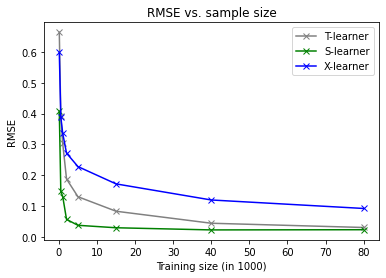

In [232]:
plt.plot([i/1000 for i in training_sizes],rmse_dict['t'],c='gray',marker='x')
plt.plot([i/1000 for i in training_sizes],rmse_dict['s'],c='green',marker='x')
plt.plot([i/1000 for i in training_sizes],rmse_dict['x'],c='blue',marker='x')
plt.title('RMSE vs. sample size')
plt.xlabel('Training size (in 1000)')
plt.ylabel('RMSE')
plt.legend(labels=['T-learner','S-learner','X-learner'])
plt.savefig(path+'fig3_rmse_BL='+str(base_learner)[:str(base_learner).find('(')])
plt.show()

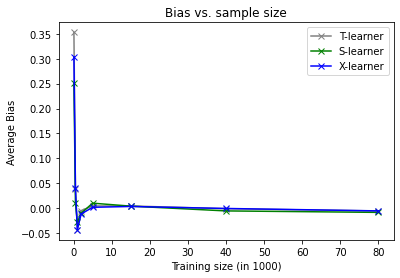

In [233]:
plt.plot([i/1000 for i in training_sizes],bias_dict['t'],c='gray',marker='x')
plt.plot([i/1000 for i in training_sizes],bias_dict['s'],c='green',marker='x')
plt.plot([i/1000 for i in training_sizes],bias_dict['x'],c='blue',marker='x')
plt.title('Bias vs. sample size')
plt.xlabel('Training size (in 1000)')
plt.ylabel('Average Bias')
plt.legend(labels=['T-learner','S-learner','X-learner'])
plt.savefig(path+'fig3_bias_BL='+str(base_learner)[:str(base_learner).find('(')])
plt.show()

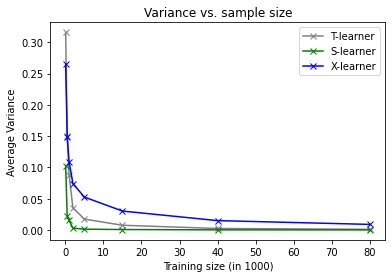

In [234]:
plt.plot([i/1000 for i in training_sizes],var_dict['t'],c='gray',marker='x')
plt.plot([i/1000 for i in training_sizes],var_dict['s'],c='green',marker='x')
plt.plot([i/1000 for i in training_sizes],var_dict['x'],c='blue',marker='x')
plt.title('Variance vs. sample size')
plt.xlabel('Training size (in 1000)')
plt.ylabel('Average Variance')
plt.legend(labels=['T-learner','S-learner','X-learner'])
plt.savefig(path+'fig3_variance_BL='+str(base_learner)[:str(base_learner).find('(')])
plt.show()